# OpenML CC18 Metalearning Benchmark

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandera as pa
import plotly.express as px
import re
import seaborn as sns

from pathlib import Path

In [4]:
# environment variables
JOB = 338
RESULTS_ROOT = Path("..") / "floyd_outputs"

## Training

In [5]:
training_results = (
    pd.concat([
        pd.read_csv(path) for path in
        (RESULTS_ROOT / str(JOB)).glob("metalearn_training_results_trial_*.csv")
    ])
    .sort_values(["trial_num", "episode"])
)
training_results.head(3)

,episode,data_env_names,scorers,losses,mean_rewards,aggregate_gradients,mean_validation_scores,std_validation_scores,best_validation_scores,n_successful_mlfs,n_unique_mlfs,n_unique_hyperparams,mlf_diversity,hyperparam_diversity,entropy_coefficient,trial_num,entropy_coef,entropy_coef_anneal_to,learning_rate,meta_reward_multiplier
0,1,openml.socmob,roc_auc,1.043152,0.430504,0.595675,0.797229,0.195009,0.984474,54,84,100,1.566038,1.867925,0.0,0,0.0,0.0,0.0,1.0
1,2,openml.bank-marketing,roc_auc,-0.041313,0.151328,0.743848,0.657946,0.130090,0.872673,23,87,100,3.909091,4.500000,0.0,0,0.0,0.0,0.0,1.0
2,3,openml.house_8l,roc_auc,0.486036,0.304472,0.708735,0.691982,0.151382,0.925055,44,92,100,2.116279,2.302326,0.0,0,0.0,0.0,0.0,1.0


### Mean Rewards per Episode

It looks like the experiment output is missing training results
data for trials 1, 2, 3, and 6. Not sure why this happened, need
to check that the trail numbers are properly recorded in the
`metalearn.experiment` module.

In [6]:
training_results.query("episode == 1")

,episode,data_env_names,scorers,losses,mean_rewards,aggregate_gradients,mean_validation_scores,std_validation_scores,best_validation_scores,n_successful_mlfs,n_unique_mlfs,n_unique_hyperparams,mlf_diversity,hyperparam_diversity,entropy_coefficient,trial_num,entropy_coef,entropy_coef_anneal_to,learning_rate,meta_reward_multiplier
0,1,openml.socmob,roc_auc,1.043152,0.430504,0.595675,0.797229,0.195009,0.984474,54,84,100,1.566038,1.867925,0.0,0,0.0,0.0,0.0000,1.0
0,1,openml.analcatdata_halloffame,roc_auc,1.228940,0.227325,0.956970,0.733307,0.183331,0.975856,31,90,100,2.966667,3.300000,0.0,1,0.0,0.0,0.0005,1.0
0,1,openml.ailerons,roc_auc,1.146440,0.391754,0.614169,0.712280,0.164907,0.953036,55,94,100,1.722222,1.833333,0.0,2,0.0,0.0,0.0050,1.0
0,1,openml.sylva_agnostic,roc_auc,1.041998,0.341894,0.590309,0.743248,0.217743,0.992124,46,93,100,2.044444,2.200000,0.0,3,0.0,0.0,0.0500,1.0


In [7]:
training_results.trial_num.unique()

array([0, 1, 2, 3])

In [8]:
training_results[["trial_num", "entropy_coef_anneal_to", "learning_rate"]].drop_duplicates()

,trial_num,entropy_coef_anneal_to,learning_rate
0,0,0.0,0.0000
0,1,0.0,0.0005
0,2,0.0,0.0050
0,3,0.0,0.0500


Roughly define regret as ${validation\ score}_{max} - {validation\ score}_{mean}$
for a particular episode. Where ${validation\ score}_{max}$ is the best validation
set found by all of the hyperparameter conditions for a particular dataset.

In [9]:
optimal_validation_scores = training_results.groupby("data_env_names").best_validation_scores.max()

training_results.assign(optimal_validation_scores=lambda df: df.data_env_names.map(optimal_validation_scores))

,episode,data_env_names,scorers,losses,mean_rewards,aggregate_gradients,mean_validation_scores,std_validation_scores,best_validation_scores,n_successful_mlfs,...,n_unique_hyperparams,mlf_diversity,hyperparam_diversity,entropy_coefficient,trial_num,entropy_coef,entropy_coef_anneal_to,learning_rate,meta_reward_multiplier,optimal_validation_scores
0,1,openml.socmob,roc_auc,1.043152e+00,0.430504,5.956752e-01,0.797229,0.195009,0.984474,54,...,100,1.566038,1.867925,0.0,0,0.0,0.0,0.00,1.0,0.991905
1,2,openml.bank-marketing,roc_auc,-4.131259e-02,0.151328,7.438481e-01,0.657946,0.130090,0.872673,23,...,100,3.909091,4.500000,0.0,0,0.0,0.0,0.00,1.0,0.934778
2,3,openml.house_8l,roc_auc,4.860358e-01,0.304472,7.087351e-01,0.691982,0.151382,0.925055,44,...,100,2.116279,2.302326,0.0,0,0.0,0.0,0.00,1.0,0.934585
3,4,openml.bank32nh,roc_auc,9.933061e-01,0.322184,6.148541e-01,0.671217,0.145014,0.903439,48,...,100,1.893617,2.106383,0.0,0,0.0,0.0,0.00,1.0,0.924937
4,5,openml.kr-vs-kp,roc_auc,-3.249156e-01,0.212278,6.665863e-01,0.758136,0.223524,0.999615,28,...,100,3.185185,3.666667,0.0,0,0.0,0.0,0.00,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,openml.kdd_ipums_la_97-small,roc_auc,1.260946e-09,0.978544,7.579692e-08,0.978544,0.013252,0.995796,100,...,1,0.000000,0.000000,0.0,3,0.0,0.0,0.05,1.0,0.995796
96,97,openml.analcatdata_halloffame,roc_auc,-2.854422e-07,0.949369,1.590508e-05,0.949369,0.018615,0.977354,100,...,1,0.000000,0.000000,0.0,3,0.0,0.0,0.05,1.0,0.977354
97,98,openml.eeg-eye-state,roc_auc,-3.248967e-07,0.812830,1.598212e-05,0.812830,0.126127,0.924444,100,...,1,0.000000,0.000000,0.0,3,0.0,0.0,0.05,1.0,0.966915
98,99,openml.higgs,roc_auc,5.006891e-04,0.610615,2.316687e-02,0.610615,0.022754,0.676547,100,...,1,0.000000,0.000000,0.0,3,0.0,0.0,0.05,1.0,0.801070


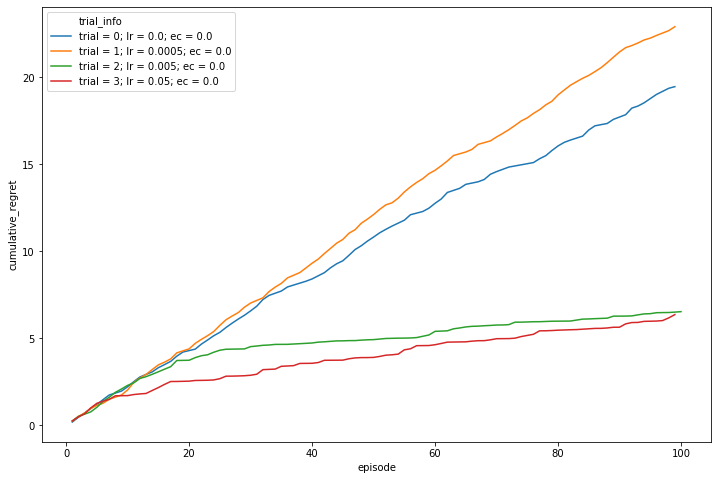

In [14]:
METRICS = [
    "losses",
    "aggregate_gradients",
    "best_validation_scores",
    "mean_rewards",
    "mean_validation_scores",
    "n_successful_mlfs",
    "mlf_diversity",
    "hyperparam_diversity",
]


agg_performance_results = (
    training_results
    .assign(
        optimal_validation_scores=lambda df: df.data_env_names.map(
            training_results.groupby("data_env_names").best_validation_scores.max())
    )
    .assign(regret=lambda df: df.optimal_validation_scores - df.mean_validation_scores)
    .groupby([
        "trial_num", "entropy_coef_anneal_to", "learning_rate",
    ])
    .apply(lambda df: df.assign(cumulative_regret=df.regret.cumsum()))
    .reset_index(drop=True)
    .assign(
        trial_info=lambda df: (
            "trial = " + df.trial_num.astype(str) +
            "; lr = " + df.learning_rate.astype(str) +
            "; ec = " + df.entropy_coef_anneal_to.astype(str)
        )
    )
    .pipe(lambda df: pd.concat([
        df,
        (
            df
            .set_index(["trial_info", "episode"])
            .groupby("trial_info")
            .apply(lambda df: df[METRICS].ewm(alpha=0.05).mean())
        )
    ], sort=False))
)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="cumulative_regret",
    hue="trial_info",
    ax=ax,
)

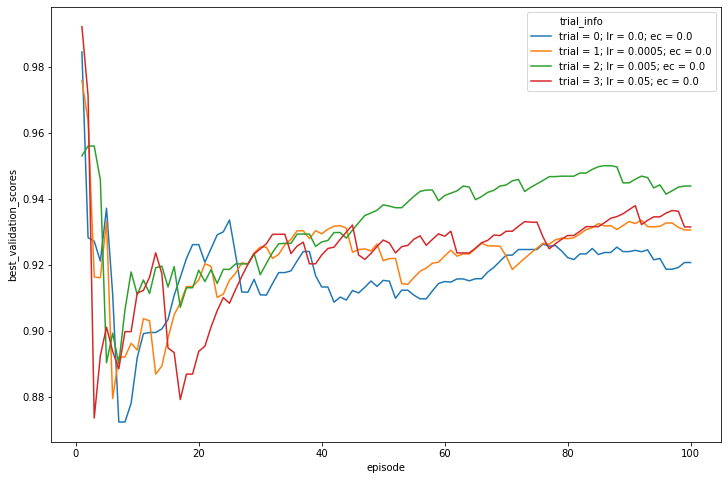

In [24]:
plot_df = (
    agg_performance_results
    .set_index(["trial_info", "episode"])
    .groupby("trial_info")
    .apply(lambda df: df[METRICS].ewm(alpha=0.01).mean())
    .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 8))

g = sns.lineplot(
    data=plot_df,
    x="episode",
    y="best_validation_scores",
    hue="trial_info",
    ax=ax,
)

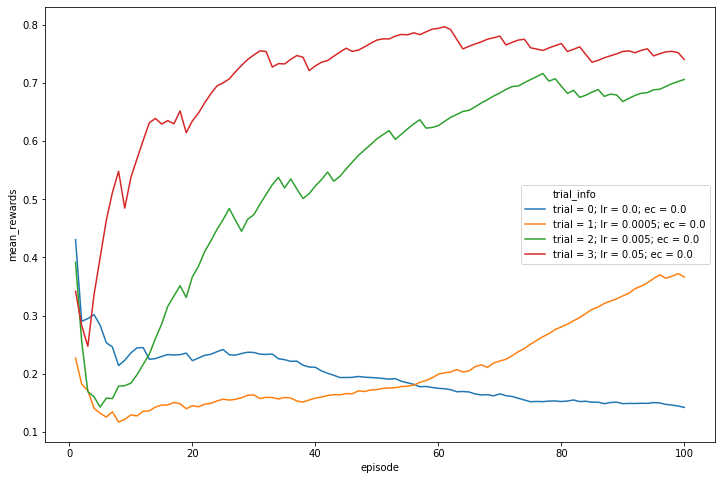

In [17]:
plot_df = (
    agg_performance_results
    .set_index(["trial_info", "episode"])
    .groupby("trial_info")
    .apply(lambda df: df[METRICS].ewm(alpha=0.01).mean())
    .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 8))

g = sns.lineplot(
    data=plot_df,
    x="episode",
    y="mean_rewards",
    hue="trial_info",
    ax=ax,
)

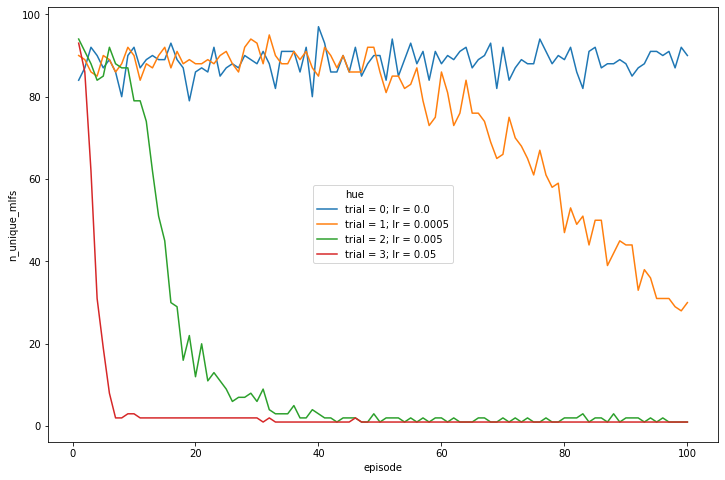

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=training_results.assign(
        hue=lambda df: (
            "trial = " + df.trial_num.astype(str) +
            "; lr = " + df.learning_rate.astype(str)
        )
    ),
    x="episode",
    y="n_unique_mlfs",
    hue="hue",
    ax=ax,
)

#### Plot Performance per Trial

In [20]:
hyperparameters = ["entropy_coef_anneal_to", "learning_rate"]
metrics = ["mean_validation_scores", "mean_rewards", "n_unique_mlfs"]
statistics = ["mean", "median"]

summary_performance_df = (
    training_results
    .groupby(["episode", "trial_num"])
    .agg({metric: statistics for metric in metrics})
    .set_axis(
        labels=[
            f"{stat}_of_{metric}"
            for metric in metrics
            for stat in statistics],
        axis="columns",
        inplace=False
    )
#     .reset_index()
)
summary_performance_df.head(3)

mean_of_mean_validation_scores  \
episode trial_num                                   
1       0                                0.797229   
        1                                0.733307   
        2                                0.712280   

                   median_of_mean_validation_scores  mean_of_mean_rewards  \
episode trial_num                                                           
1       0                                  0.797229              0.430504   
        1                                  0.733307              0.227325   
        2                                  0.712280              0.391754   

                   median_of_mean_rewards  mean_of_n_unique_mlfs  \
episode trial_num                                                  
1       0                        0.430504                     84   
        1                        0.227325                     90   
        2                        0.391754                     94   

                   median_of_n_unique_mlfs  
episode trial_num                           
1       0                               84  
        1                               90  
        2                               94

## Inference

In [36]:
check_betw_zero_one = pa.Check(lambda s: (0.0 <= s) & (s <= 1.0))

INFERENCE_RESULT_SCHEMA = pa.DataFrameSchema(
    columns={
        "data_env": pa.Column(pa.String),
        "n_inference_steps": pa.Column(pa.Int),
        "is_valid": pa.Column(pa.Bool),
        "reward": pa.Column(pa.Float),
        "validation_score": pa.Column(pa.Float),
    },
    coerce=True,
)

@pa.check_output(INFERENCE_RESULT_SCHEMA)
def data_to_longform(inference_results):
    return (
        inference_results
        [["data_env", "n_inference_steps", "key", "value"]]
        .dropna(subset=["value"])
        .pivot_table(
            index=["data_env", "n_inference_steps"],
            columns="key",
            values="value",
            aggfunc=lambda x: x,
        )
        .reset_index()
        .dropna()
        # all scores should be strings
        .loc[
            lambda df: (
                df.validation_score.map(lambda x: isinstance(x, str)) &
                df.mlf.map(lambda x: isinstance(x, str)) &
                df.reward.map(lambda x: isinstance(x, str)) &
                df.is_valid.map(lambda x: isinstance(x, str))
            )
        ]
        .rename_axis(None, axis=1)
        .reset_index(drop=True)
    )

In [37]:
inference_results = pd.concat([
    (
        pd.read_csv(f"../floyd_outputs/{JOB}/{env}_env_inference_results.csv")
        .pipe(data_to_longform)
        .assign(data_env_partition=env)
    ) for env in ["training", "test"]
])
inference_results.head()

,data_env,n_inference_steps,is_valid,mlf,mlf_full,reward,scorer,target_type,validation_score,data_env_partition
0,openml.2dplanes,3,True,SimpleImputer > OneHotEncoder > StandardScaler...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.500000,roc_auc,TargetType.BINARY,0.500000,training
1,openml.2dplanes,5,True,SimpleImputer > OneHotEncoder > Normalizer > P...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.931774,roc_auc,TargetType.BINARY,0.931774,training
2,openml.2dplanes,11,True,SimpleImputer > OneHotEncoder > StandardScaler...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.701935,roc_auc,TargetType.BINARY,0.701935,training
3,openml.2dplanes,12,True,SimpleImputer > OneHotEncoder > Normalizer > R...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.500000,roc_auc,TargetType.BINARY,0.500000,training
4,openml.2dplanes,17,True,SimpleImputer > OneHotEncoder > Normalizer > R...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.819045,roc_auc,TargetType.BINARY,0.819045,training


## Plot Validation Scores

In [23]:
px.line(
    inference_results.query("data_env_partition == 'training'"),
    x="n_inference_steps",
    y="reward",
    template="plotly_white",
    color="data_env",
)

NameError: name 'inference_results' is not defined

### Plot of Test Data Environment Validation Scores

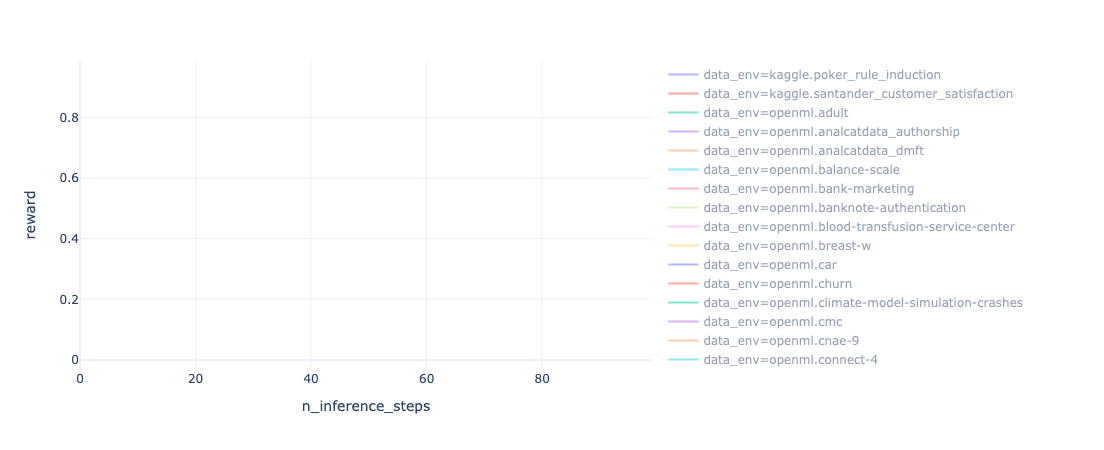

In [24]:
px.line(
    inference_results.query("data_env_partition == 'test'"),
    x="n_inference_steps",
    y="reward",
    template="plotly_white",
    color="data_env",
)

In [23]:
with pd.option_context("display.max_rows", 200):
    display(
        inference_results
        .groupby(["data_env_partition", "data_env"])
        .apply(lambda df: df.loc[df.validation_score.idxmax()])
        .reset_index(drop=True)
        .groupby("data_env_partition")
        .apply(lambda df: df.sort_values("validation_score"))
        .head()
    )

data_env  n_inference_steps  \
data_env_partition                                                             
test               4              openml.analcatdata_dmft                 15   
                   0          kaggle.poker_rule_induction                  0   
                   24  openml.first-order-theorem-proving                 92   
                   13                          openml.cmc                 86   
                   42                  openml.numerai28.6                 35   

                       is_valid  \
data_env_partition                
test               4       True   
                   0       True   
                   24      True   
                   13      True   
                   42      True   

                                                                     mlf  \
data_env_partition                                                         
test               4   SimpleImputer > OneHotEncoder > MinMaxScaler >...   
                   0   SimpleImputer > OneHotEncoder > MinMaxScaler >...   
                   24  SimpleImputer > OneHotEncoder > MinMaxScaler >...   
                   13  SimpleImputer > OneHotEncoder > MinMaxScaler >...   
                   42  SimpleImputer > OneHotEncoder > MinMaxScaler >...   

                                                                mlf_full  \
data_env_partition                                                         
test               4   {'SimpleImputer': ColumnTransformer(n_jobs=Non...   
                   0   {'SimpleImputer': ColumnTransformer(n_jobs=Non...   
                   24  {'SimpleImputer': ColumnTransformer(n_jobs=Non...   
                   13  {'SimpleImputer': ColumnTransformer(n_jobs=Non...   
                   42  {'SimpleImputer': ColumnTransformer(n_jobs=Non...   

                         reward    scorer            target_type  \
data_env_partition                                                 
test               4   0.234471  f1_macro  TargetType.MULTICLASS   
                   0   0.502079  f1_macro  TargetType.MULTICLASS   
                   24  0.511297  f1_macro  TargetType.MULTICLASS   
                   13  0.567958  f1_macro  TargetType.MULTICLASS   
                   42  0.595834   roc_auc      TargetType.BINARY   

                       validation_score data_env_partition  
data_env_partition                                          
test               4           0.234471               test  
                   0           0.502079               test  
                   24          0.511297               test  
                   13          0.567958               test  
                   42          0.595834               test